### Ejercicio 5

Para trabajar esta parte, vamos a realizar el scraping de datos relativos al mercado eléctrico español mediante una API que proporciona datos de generación, demanda, transporte, etc. de electricidad publicado por REE (Red Eléctrica de España).

La documentacion de la API está disponible en: https://www.ree.es/en/apidatos

En primer lugar, debemos cargar las librerías que vamos a utilizar y definir la URL común a todas las solicitudes (_requests_) que vamos a realizar (url_base) y especificar los paramétros de la petición que deseemos hacer:

In [10]:
# Cargar librerías
# ToDo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import logging
import time
import requests
import json

In [5]:
FORMAT = '%(asctime)-15s - %(message)s'
logging.basicConfig(format=FORMAT)
logger = logging.getLogger("main.py")
logger.setLevel("INFO")

In [5]:
categoria = 'generacion'
subcategoria = 'estructura-generacion'
start_date = '2022-01-01T00:00'
end_date =  '2022-12-31T23:59'
freq = 'year'
com_aut = '9'
geo_limit = 'ccaa'
geo_trunc = 'electric_system'

In [6]:
# Definir la URL común a todas las requests de la web que vamos a scrapear
url_base = 'https://apidatos.ree.es/es/datos/'
url_compl = f'{categoria}/{subcategoria}?start_date={start_date}&end_date={end_date}&time_trunc={freq}&geo_trunc={geo_trunc}&geo_limit={geo_limit}&geo_ids={com_aut}'

- Generar los datos anuales 2022 para la CCAA Catalunya

In [7]:
# Realizamos el requests
resp_cat = requests.get(url_base+url_compl)

print(f'Respuesta generación electríca Catalunya: {resp_cat.status_code}')

Respuesta generación electríca Catalunya: 200


In [12]:
type(resp_cat.json())
resp_cat.json()

{'data': {'type': 'Generación por tecnología',
  'id': 'gen1',
  'attributes': {'title': 'Generación por tecnología',
   'last-update': None,
   'description': None},
  'meta': {'cache-control': {'cache': 'MISS'}}},
 'included': [{'type': 'Hidráulica',
   'id': '10330',
   'groupId': '1',
   'attributes': {'title': 'Hidráulica',
    'description': None,
    'color': '#0090d1',
    'type': 'Renovable',
    'magnitude': None,
    'composite': False,
    'last-update': '2022-10-25T16:31:53.000+02:00',
    'values': [{'value': 1876457.168,
      'percentage': 0.07556894917785026,
      'datetime': '2022-01-01T00:00:00.000+01:00'}]}},
  {'type': 'Turbinación bombeo',
   'id': '1694',
   'groupId': '1',
   'attributes': {'title': 'Turbinación bombeo',
    'description': None,
    'color': '#007cf9',
    'type': 'No-Renovable',
    'magnitude': None,
    'composite': False,
    'last-update': '2022-10-25T16:31:53.000+02:00',
    'values': [{'value': 104159.795,
      'percentage': 0.004194738

In [13]:
resp_cat.json().keys()

dict_keys(['data', 'included'])

In [31]:
resp_cat.json().get('included')[10].items()

dict_items([('type', 'Residuos renovables'), ('id', '10337'), ('groupId', '1'), ('attributes', {'title': 'Residuos renovables', 'description': None, 'color': '#a0a0a0', 'type': 'Renovable', 'magnitude': None, 'composite': False, 'last-update': '2022-10-25T16:31:54.000+02:00', 'values': [{'value': 84928.068, 'percentage': 0.0034202351984966867, 'datetime': '2022-01-01T00:00:00.000+01:00'}]})])

# 1.

Para el año 2021, devolver el porcentaje anual de generación renovable y no renovable (evolucion-renovable-no-renovable) para Aragón y Cataluña.

In [12]:
# Inicializar los valores de los parámetros introducidos por el usuario y almacenarlos en variables

category = input("Introduzca la category: ") # ToDo
widget = input("Introduzca el wiget: ") # ToDo
fecha_inicio = input("introduzca la fecha de inicio (formato YYYY-MM-DDT00:00): ") # ToDo
fecha_fin = input("introduzca la fecha final (formato YYYY-MM-DDT23:59): ") # ToDo
freq = input("introduzca la frecuencia: (hour, day, month, year) ") # ToDo

# Introducimos las ids para Aragón y Catalunya

ccaa_ids = {
    "Aragón" : "5",
    "Catalunya" : "9"
}

ccaa_df = pd.DataFrame()

url_base = f'https://apidatos.ree.es/es/datos/{category}/{widget}'

for k, v in ccaa_ids.items():
    for geo_id in v:
        
        try:
            # Creamos los parámetros del payloads
            params = {
                "start_date": fecha_inicio,
                "end_date" : fecha_fin, 
                "time_trunc": freq,
                "geo_trunc": "electric_system",
                "geo_limit": "ccaa",
                "geo_ids": geo_id
            }

            # Obtener la respuesta a la solicitud HTML
            response = requests.get(url=url_base, params=params)

            '''
            Aplicamos un filtro si la respuesta está en un rango 
            entre 200 y 299 como respuesta ok
            '''
            if response.status_code in range(200, 299):
                print(f'Estado de la respuesta {k}:', response.status_code)

                format_data = "%Y-%m-%dT%H:%M:%S.%f%z"

                new_dict = [
                    {
                        "CCAA" : k,
                        "Type" : row['type'],
                        "Percentual" : value['percentage'] ,
                        "Datetime" : datetime.datetime.strptime(
                            value['datetime'],
                            format_data)
                    }
                    for row in response.json()['included']
                        for value in row['attributes']['values']
                ]

                temp_df = pd.DataFrame(new_dict)
                ccaa_df = pd.concat([ccaa_df, temp_df], ignore_index=True)

            else:
                print(f'Estado de la respuesta {k}:', response.status_code)
        
        except Exception as e:
            print(e)

Estado de la respuesta Aragón: 200
Estado de la respuesta Catalunya: 200


In [13]:
ccaa_df

,CCAA,Type,Percentual,Datetime
0,Aragón,Renovable,0.777081,2021-01-01 00:00:00+01:00
1,Aragón,No renovable,0.222919,2021-01-01 00:00:00+01:00
2,Catalunya,Renovable,0.169963,2021-01-01 00:00:00+01:00
3,Catalunya,No renovable,0.830037,2021-01-01 00:00:00+01:00


In [14]:
ccaa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype                    
---  ------      --------------  -----                    
 0   CCAA        4 non-null      object                   
 1   Type        4 non-null      object                   
 2   Percentual  4 non-null      float64                  
 3   Datetime    4 non-null      datetime64[ns, UTC+01:00]
dtypes: datetime64[ns, UTC+01:00](1), float64(1), object(2)
memory usage: 256.0+ bytes


2. Obtener la evolución anual del balance de renovables y no renovables para Aragón y Cataluña de 2017 a 2021 (ambos incluidos). Mostrar el resultado tanto en fomrato DataFrame como en una gráfica que ilustre la evolución temporal. Para la visualización se recomienda el uso de la librería matplotlib.

In [15]:
# Cargamos las librerías
import re
import matplotlib.pyplot as plt

In [16]:
# Inicializar los valores de los parámetros introducidos por el usuario y almacenarlos en variables

category = input("Introduzca la category: ") # ToDo
widget = input("Introduzca el wiget: ") # ToDo
fecha_inicio = input("introduzca la fecha de inicio (formato YYYY-MM-DDT00:00): ") # ToDo
fecha_fin = input("introduzca la fecha final (formato YYYY-MM-DDT23:59): ") # ToDo
freq = input("introduzca la frecuencia: (hour, day, month, year) ") # ToDo

# Introducimos las ids para Aragón y Catalunya

ccaa_ids = {
    "Aragón" : "5",
    "Catalunya" : "9"
}

tipo_energia = "Generación"
ccaa_df = pd.DataFrame()

url_base = f'https://apidatos.ree.es/es/datos/{category}/{widget}'

for k, v in ccaa_ids.items():
    for geo_id in v:
        
        try:
            # Creamos los parámetros del payloads
            params = {
                "start_date": fecha_inicio,
                "end_date" : fecha_fin, 
                "time_trunc": freq,
                "geo_trunc": "electric_system",
                "geo_limit": "ccaa",
                "geo_ids": geo_id
            }

            # Obtener la respuesta a la solicitud HTML
            response = requests.get(url=url_base, params=params)

            '''
            Aplicamos un filtro si la respuesta está en un rango 
            entre 200 y 299 como respuesta ok
            '''
            if response.status_code in range(200, 299):
                print(f'Estado de la respuesta {k}:', response.status_code)

                format_data = "%Y-%m-%dT%H:%M:%S.%f%z"

                new_dict = [
                    {
                        "CCAA" : k,
                        "Type" : c['type'],
                        "Valor" : ra['value'] ,
                        "Datetime" : datetime.datetime.strptime(
                            ra['datetime'],
                            format_data)
                    }
                    for row in response.json()['included']
                        for c in row['attributes']['content']
                            if re.search(tipo_energia, c.get('type'))
                                for ra in c['attributes']['values']

                ]

                temp_df = pd.DataFrame(new_dict)
                ccaa_df = pd.concat([ccaa_df, temp_df], ignore_index=True)

            else:
                print(f'Estado de la respuesta {k}:', response.status_code)
        
        except Exception as e:
            print(e)

Estado de la respuesta Aragón: 200
Estado de la respuesta Catalunya: 200


In [17]:
ccaa_df

,CCAA,Type,Valor,Datetime
0,Aragón,Generación renovable,7.462987e+06,2017-01-01 00:00:00+01:00
1,Aragón,Generación renovable,8.564999e+06,2018-01-01 00:00:00+01:00
2,Aragón,Generación renovable,8.293142e+06,2019-01-01 00:00:00+01:00
3,Aragón,Generación renovable,1.233336e+07,2020-01-01 00:00:00+01:00
4,Aragón,Generación renovable,1.513617e+07,2021-01-01 00:00:00+01:00
5,Aragón,Generación no renovable,9.271154e+06,2017-01-01 00:00:00+01:00
6,Aragón,Generación no renovable,6.632646e+06,2018-01-01 00:00:00+01:00
7,Aragón,Generación no renovable,7.058639e+06,2019-01-01 00:00:00+01:00
8,Aragón,Generación no renovable,5.718906e+06,2020-01-01 00:00:00+01:00
9,Aragón,Generación no renovable,4.342064e+06,2021-01-01 00:00:00+01:00


In [20]:
ccaa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype                    
---  ------    --------------  -----                    
 0   CCAA      20 non-null     object                   
 1   Type      20 non-null     object                   
 2   Valor     20 non-null     float64                  
 3   Datetime  20 non-null     datetime64[ns, UTC+01:00]
dtypes: datetime64[ns, UTC+01:00](1), float64(1), object(2)
memory usage: 768.0+ bytes


Text(0.5, 1.0, 'Balance Electríco por CCAA')

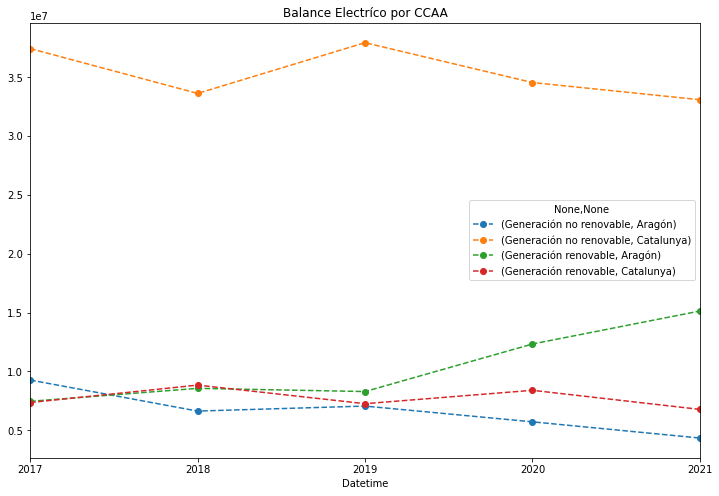

In [27]:
ccaa_df.set_index('Datetime', drop=True).sort_index().groupby(
    ['Type','CCAA'])['Valor'].plot(
        style='--o', legend=True, figsize=(12,8)
    )
plt.title('Balance Electríco por CCAA')